In [6]:
import os
import numpy as np
import splitfolders
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2 # , ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model


from utils.plots import plot_sample_images, plot_training_history, plot_confusion_matrix, plot_image

print("Versão do Tensorflow:")
print(tf.__version__)

Versão do Tensorflow:
2.20.0


# Classificação de Elementos Eletrônicos com TensorFlow e Keras - Tarefa 24

## Carregar dados

Found 5423 images belonging to 17 classes.
Found 671 images belonging to 17 classes.
Found 688 images belonging to 17 classes.


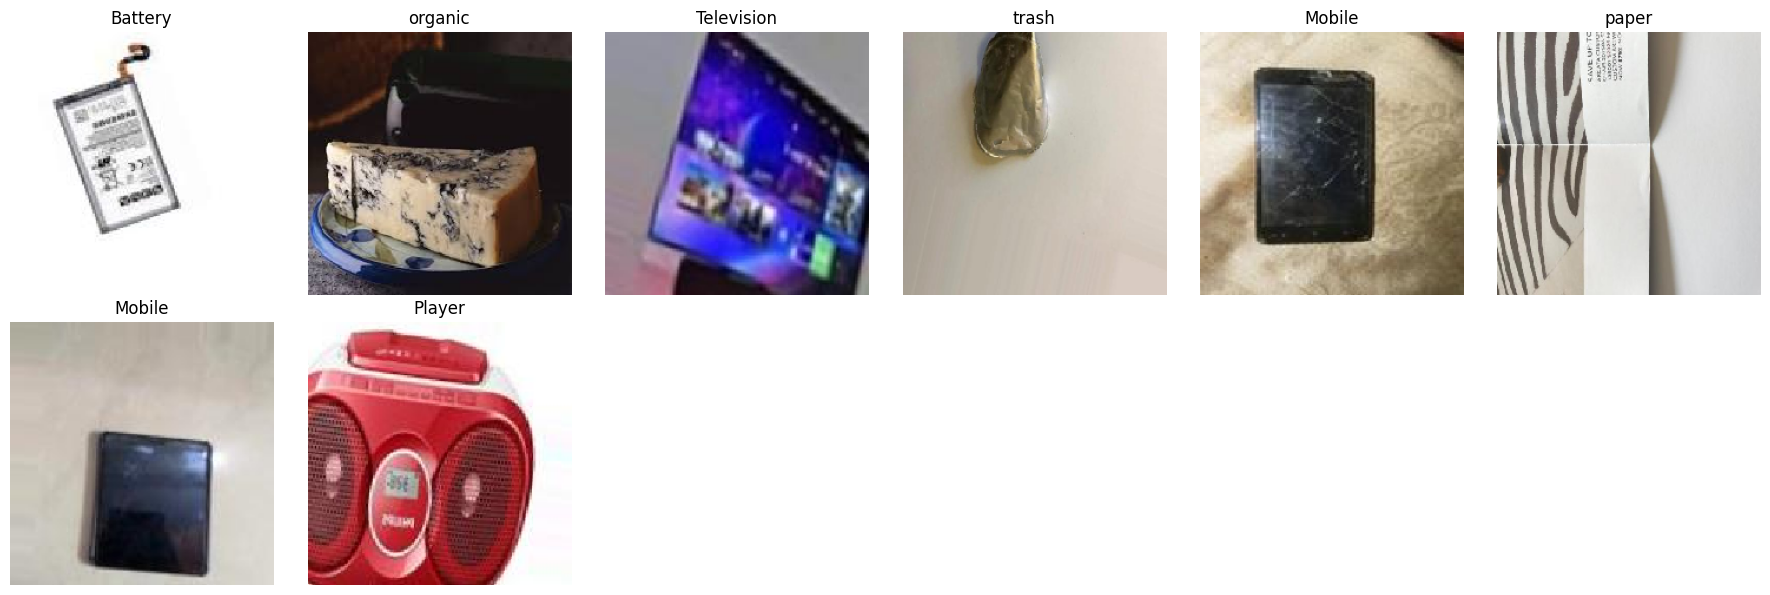

In [7]:

""" # Dividir os dados em treino, validação e teste
splitfolders.ratio(
    input='../data/balanced_waste_images',
    output='../data/split_data',
    seed=42,
    ratio=(.8, .1, .1),
    group_prefix=None,
    move=False
) """

# Configurações
IMG_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
SEED = 42
EPOCHS = 13
IMAGE_BASE_PATH = "../data/split_data"

# Data generators with preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '../data/split_data/train/',
    target_size=IMG_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    '../data/split_data/val/',
    target_size=IMG_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    '../data/split_data/test/',
    target_size=IMG_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())

plot_sample_images(train_generator, class_names)

## Criar o modelo

In [8]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
base_model.trainable = False

inputs = keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 17)             │         4,369 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,590,289 (9.88 MB)

 Trainable params: 332,305 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Treinar o modelo

In [9]:
import pickle

WEIGHTS_PATH = '../models/mobilenet_weights.weights.h5'
HISTORY_PATH = '../models/training_history.pkl'

# Verificar se os pesos existem
if os.path.exists(WEIGHTS_PATH):
    print("Carregando pesos existentes...")
    model.load_weights(WEIGHTS_PATH)
    print("Pesos carregados com sucesso!")

    # Carregar histórico se existir
    if os.path.exists(HISTORY_PATH):
        with open(HISTORY_PATH, 'rb') as f:
            history = pickle.load(f)
        print("Histórico de treinamento carregado!")
    else:
        print("Histórico de treinamento não encontrado.")
        history = None
else:
    print("Treinando novo modelo...")
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        verbose=2
    )
    # Salvar os pesos após o treinamento
    os.makedirs('../models', exist_ok=True)
    model.save_weights(WEIGHTS_PATH)
    print(f"Pesos salvos em: {WEIGHTS_PATH}")

    # Salvar o histórico de treinamento
    with open(HISTORY_PATH, 'wb') as f:
        pickle.dump(history.history, f)
    print(f"Histórico salvo em: {HISTORY_PATH}")

    # Salvar o modelo completo
    MODEL_PATH = '../models/mobilenet_model.keras'
    model.save(MODEL_PATH)
    print(f"Modelo completo salvo em: {MODEL_PATH}")

Treinando novo modelo...
Epoch 1/13
170/170 - 122s - 718ms/step - accuracy: 0.7370 - loss: 0.8290 - val_accuracy: 0.8435 - val_loss: 0.4567
Epoch 2/13
170/170 - 120s - 705ms/step - accuracy: 0.8827 - loss: 0.3565 - val_accuracy: 0.8674 - val_loss: 0.3963
Epoch 3/13
170/170 - 123s - 722ms/step - accuracy: 0.9224 - loss: 0.2357 - val_accuracy: 0.8852 - val_loss: 0.3502
Epoch 4/13
170/170 - 124s - 729ms/step - accuracy: 0.9425 - loss: 0.1655 - val_accuracy: 0.8882 - val_loss: 0.3385
Epoch 5/13
170/170 - 125s - 732ms/step - accuracy: 0.9615 - loss: 0.1142 - val_accuracy: 0.8987 - val_loss: 0.3554
Epoch 6/13
170/170 - 118s - 696ms/step - accuracy: 0.9709 - loss: 0.0876 - val_accuracy: 0.9016 - val_loss: 0.3612
Epoch 7/13
170/170 - 119s - 698ms/step - accuracy: 0.9823 - loss: 0.0614 - val_accuracy: 0.8912 - val_loss: 0.3933
Epoch 8/13
170/170 - 122s - 715ms/step - accuracy: 0.9836 - loss: 0.0558 - val_accuracy: 0.8867 - val_loss: 0.3670
Epoch 9/13
170/170 - 123s - 722ms/step - accuracy: 0.98

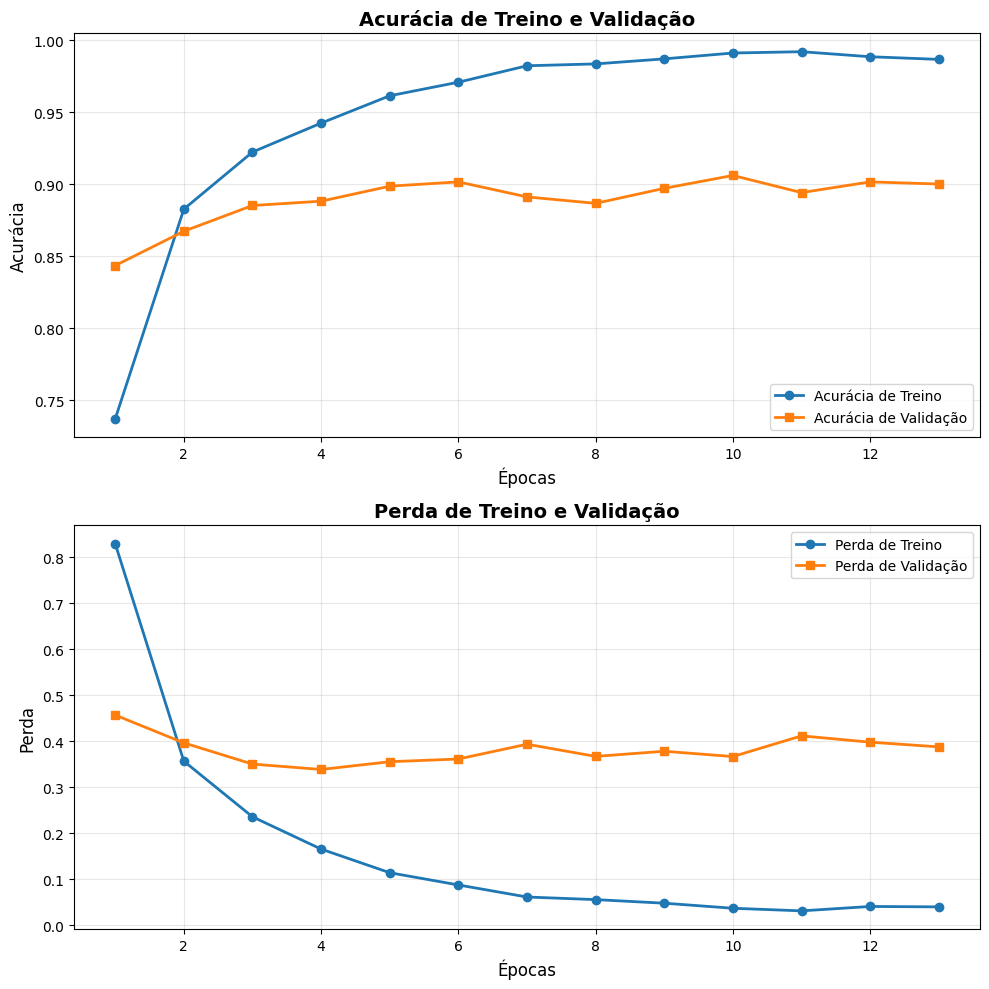

In [10]:
if history is not None:
    plot_training_history(history)

## Avaliar o modelo

In [11]:
# Previsões
y_pred = model.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred_classes, target_names=class_names))

22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 668ms/step
                 precision    recall  f1-score   support

        Battery       0.97      0.88      0.92        41
       Keyboard       1.00      0.98      0.99        41
      Microwave       0.90      0.88      0.89        41
         Mobile       0.91      0.97      0.94        40
          Mouse       1.00      0.90      0.95        41
            PCB       0.95      0.93      0.94        41
         Player       0.83      0.95      0.89        41
        Printer       0.90      0.95      0.93        40
     Television       0.88      0.85      0.86        41
Washing Machine       1.00      0.97      0.99        40
      cardboard       0.90      0.93      0.91        40
          glass       0.77      0.82      0.80        40
          metal       0.84      0.65      0.73        40
        organic       0.93      0.93      0.93        40
          paper       0.82      0.78      0.79        40
        plastic       0.66      0.82      0.7

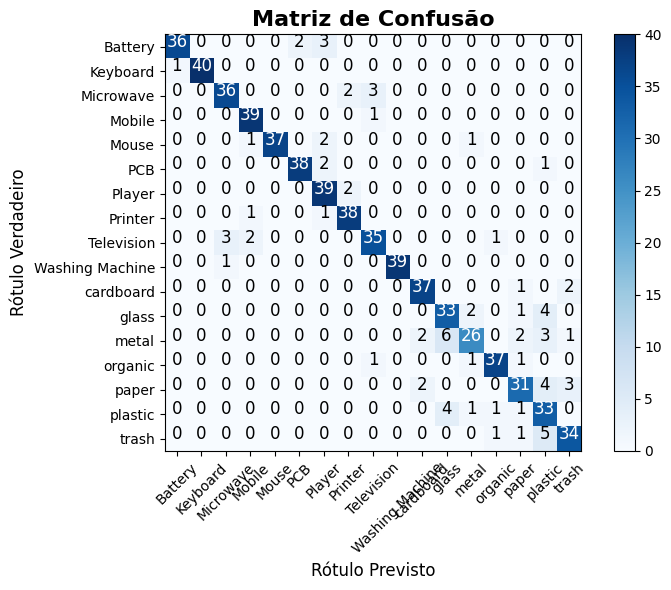

In [12]:
# Gerar matriz de confusão
cm = confusion_matrix(y_true, y_pred_classes)

plot_confusion_matrix(cm, class_names)

## TensorFlow Lite - Float32

### Converter o modelo para TensorFlow Lite Float32

In [13]:
# ----------------------------
# CONVERTER PARA O TFLITE (FLOAT32)
# ----------------------------

# Define o nome do arquivo TFLite de saída
tflite_float_path = "../models/waste_classification_float32.tflite"

# Cria um conversor TFLite a partir de um modelo Keras
converter_float = tf.lite.TFLiteConverter.from_keras_model(model)

# Não quantiza (continua float32), mas faz otimizações internas no grafo
converter_float.optimizations = [tf.lite.Optimize.DEFAULT]

# Converte o modelo para TFLite
tflite_model_float = converter_float.convert()

# Salva o arquivo .tflite no disco
os.makedirs('../models', exist_ok=True)
with open(tflite_float_path, "wb") as f:
    f.write(tflite_model_float)

print("Modelo TFLite float32 salvo em:", tflite_float_path)

INFO:tensorflow:Assets written to: /tmp/tmpm6t6ovrk/assets


INFO:tensorflow:Assets written to: /tmp/tmpm6t6ovrk/assets


Saved artifact at '/tmp/tmpm6t6ovrk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_314')
Output Type:
  TensorSpec(shape=(None, 17), dtype=tf.float32, name=None)
Captures:
  127596574465232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127596574465616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127596998193616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127596574465424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127596574465040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127596574465808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127596998185552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127596998193040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127596998185744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127596998194192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127596998

W0000 00:00:1764329947.038894   12781 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1764329947.038922   12781 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-11-28 08:39:07.039305: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpm6t6ovrk
2025-11-28 08:39:07.050063: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-11-28 08:39:07.050093: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpm6t6ovrk
I0000 00:00:1764329947.160238   12781 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
2025-11-28 08:39:07.191689: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-11-28 08:39:07.871549: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpm6t6ovrk
2025-11-28 08:39:08.051886: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

### Inferência com o modelo TensorFlow Lite Float32

INPUT (float32): [{'name': 'serving_default_keras_tensor_314:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
OUTPUT (float32): [{'name': 'StatefulPartitionedCall_1:0', 'index': 175, 'shape': array([ 1, 17], dtype=int32), 'shape_signature': array([-1, 17], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


/home/matheus/Documentos/Meus Codes/tarefa24_ia_embarcatech/.venv/lib/python3.13/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


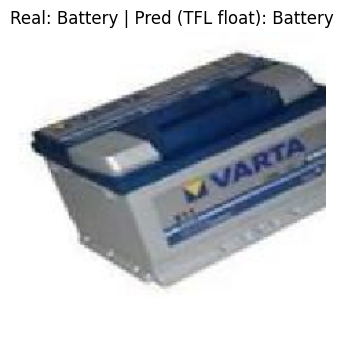

Probabilidades (float32): [9.9680448e-01 4.7529660e-08 6.0154935e-07 1.5522929e-08 1.5223887e-07
 4.9960590e-07 2.3586000e-04 2.9574828e-03 1.2026025e-08 2.3842682e-08
 2.2028221e-08 1.6934870e-09 5.8234140e-11 3.4918088e-07 8.0500984e-10
 4.8259244e-07 5.5873674e-08]


In [14]:
# ----------------------------
# INFERÊNCIA COM O TFLite FLOAT32
# ----------------------------

# Carregar modelo TFLite float32
interpreter_float = tf.lite.Interpreter(model_path=tflite_float_path)
interpreter_float.allocate_tensors()

input_details_f = interpreter_float.get_input_details()
output_details_f = interpreter_float.get_output_details()

print("INPUT (float32):", input_details_f)
print("OUTPUT (float32):", output_details_f)

# Resetar o gerador de teste
test_generator.reset()

# Pegar um batch de teste
test_images, test_labels = next(test_generator)

# Escolher uma imagem do batch
idx = 0
img = test_images[idx]
true_label_idx = np.argmax(test_labels[idx])
true_label = class_names[true_label_idx]

# Preparar entrada
input_data = np.expand_dims(img, axis=0).astype(np.float32)

interpreter_float.set_tensor(input_details_f[0]["index"], input_data)
interpreter_float.invoke()
output_data = interpreter_float.get_tensor(output_details_f[0]["index"])

pred_idx = int(np.argmax(output_data[0]))
pred_class = class_names[pred_idx]

plot_image(img, f"Real: {true_label} | Pred (TFL float): {pred_class}")

print("Probabilidades (float32):", output_data[0])

## TensorFlow Lite - Int8

### Converter o modelo para TensorFlow Lite

In [15]:
# ----------------------------
# CONVERTER PARA O TFLITE INT8 (TinyML)
# ----------------------------

# Define o nome do arquivo de saída
tflite_int8_path = "../models/waste_classification_int8.tflite"

# Função fornece amostras reais do dataset para calibração
def representative_data_gen():
    # Resetar o gerador
    train_generator.reset()
    # Usar 100 imagens para calibrar
    for _ in range(10):  # 10 batches de 32 imagens = 320 amostras
        images, _ = next(train_generator)
        for img in images:
            yield [np.expand_dims(img, axis=0).astype(np.float32)]

# Criação do conversor TFLite
converter_int8 = tf.lite.TFLiteConverter.from_keras_model(model)

# Ativa a quantização e otimização
converter_int8.optimizations = [tf.lite.Optimize.DEFAULT]

# Informa ao conversor o dataset representativo
converter_int8.representative_dataset = representative_data_gen

# Quantização total INT8 (pesos + ativação + IO)
converter_int8.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_int8.inference_input_type = tf.int8
converter_int8.inference_output_type = tf.int8

# Converte o modelo
tflite_model_int8 = converter_int8.convert()

# Salva o arquivo
with open(tflite_int8_path, "wb") as f:
    f.write(tflite_model_int8)

print("Modelo TFLite INT8 salvo em:", tflite_int8_path)

INFO:tensorflow:Assets written to: /tmp/tmpo0ykm5dj/assets


INFO:tensorflow:Assets written to: /tmp/tmpo0ykm5dj/assets


Saved artifact at '/tmp/tmpo0ykm5dj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_314')
Output Type:
  TensorSpec(shape=(None, 17), dtype=tf.float32, name=None)
Captures:
  127596574465232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127596574465616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127596998193616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127596574465424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127596574465040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127596574465808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127596998185552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127596998193040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127596998185744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127596998194192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127596998

/home/matheus/Documentos/Meus Codes/tarefa24_ia_embarcatech/.venv/lib/python3.13/site-packages/tensorflow/lite/python/convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1764329953.819779   12781 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1764329953.819805   12781 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-11-28 08:39:13.819989: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpo0ykm5dj
2025-11-28 08:39:13.831853: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-11-28 08:39:13.831875: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpo0ykm5dj
2025-11-28 08:39:13.956139: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-11-28 08:39:14.594931: I tensorflow/cc/saved_model/loader.cc:220] Running initialization

Modelo TFLite INT8 salvo em: ../models/waste_classification_int8.tflite


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8
2025-11-28 08:39:29.330612: W tensorflow/compiler/mlir/lite/flatbuffer_export.cc:3705] Skipping runtime version metadata in the model. This will be generated by the exporter.


### Inferência com o modelo TensorFlow Lite Int8

/home/matheus/Documentos/Meus Codes/tarefa24_ia_embarcatech/.venv/lib/python3.13/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


INPUT (int8): [{'name': 'serving_default_keras_tensor_314:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.003921568859368563, -128), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
OUTPUT (int8): [{'name': 'StatefulPartitionedCall_1:0', 'index': 175, 'shape': array([ 1, 17], dtype=int32), 'shape_signature': array([-1, 17], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


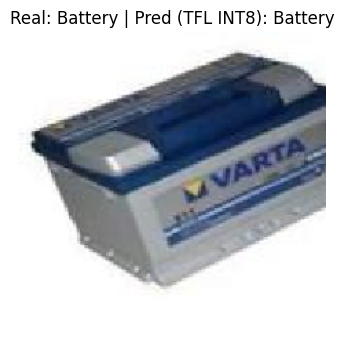

Logits dequantizados (INT8): [0.99609375 0.         0.         0.         0.         0.
 0.         0.00390625 0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


In [16]:
# ----------------------------
# INFERÊNCIA COM O TFLite INT8
# ----------------------------

# Carregar modelo TFLite INT8
interpreter_int8 = tf.lite.Interpreter(model_path=tflite_int8_path)
interpreter_int8.allocate_tensors()

input_details_i = interpreter_int8.get_input_details()
output_details_i = interpreter_int8.get_output_details()

print("INPUT (int8):", input_details_i)
print("OUTPUT (int8):", output_details_i)

# Resetar o gerador de teste
test_generator.reset()

# Pegar um batch de teste
test_images, test_labels = next(test_generator)

# Mesma imagem de teste
idx = 0
img = test_images[idx]
true_label_idx = np.argmax(test_labels[idx])
true_label = class_names[true_label_idx]

# Preparar entrada: quantizar a imagem [0,1] para int8
input_scale, input_zero_point = input_details_i[0]["quantization"]

img_float = np.expand_dims(img, axis=0).astype(np.float32)
input_data_int8 = img_float / input_scale + input_zero_point
input_data_int8 = np.clip(input_data_int8, -128, 127).astype(np.int8)

interpreter_int8.set_tensor(input_details_i[0]["index"], input_data_int8)
interpreter_int8.invoke()
output_data_int8 = interpreter_int8.get_tensor(output_details_i[0]["index"])

# Saída também é int8 – desquantizar para obter probabilidades aproximadas
output_scale, output_zero_point = output_details_i[0]["quantization"]
logits_dequant = (output_data_int8.astype(np.float32) - output_zero_point) * output_scale

pred_idx_int8 = int(np.argmax(logits_dequant[0]))
pred_class_int8 = class_names[pred_idx_int8]

plot_image(img, f"Real: {true_label} | Pred (TFL INT8): {pred_class_int8}")

print("Logits dequantizados (INT8):", logits_dequant[0])